## Описание проекта
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Загружаем предоставленные данные

In [2]:
hypothesis  = pd.read_csv('/datasets/hypothesis.csv')
orders  = pd.read_csv('/datasets/orders.csv')
visitors  = pd.read_csv('/datasets/visitors.csv')

### Предобработка данных
Сначала проверим данные

In [3]:
display(hypothesis.head(5))
display(orders.head(5))
display(visitors.head(5))
print(hypothesis.info())
print(orders.info())
print(visitors.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 colum

Даты в датасетах orders и visitors представлены в неправильном формате. Переведем в правильный

In [4]:
orders['date'] = pd.to_datetime(orders['date'])#.dt.date
visitors['date'] = pd.to_datetime(visitors['date'])

In [5]:
print(orders.info())
print(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


Проверим на пропуски данных

In [6]:
print(hypothesis.isna().count())
print(orders.isna().count())
print(visitors.isna().count())

Hypothesis    9
Reach         9
Impact        9
Confidence    9
Efforts       9
dtype: int64
transactionId    1197
visitorId        1197
date             1197
revenue          1197
group            1197
dtype: int64
date        62
group       62
visitors    62
dtype: int64


Пропусков не наблюдается.

Проверим на дубликаты

In [7]:
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


Дубликатов нет. Сомнительно, что они бы здесь нашлись, но проверить стоило.

Приведем названия полей к стандарту.

In [8]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

Предобработка закончена

## Часть 1. Приоритизация гипотез.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Задача

    Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
    Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
    Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Фреймворк ICE служит для приоритизации гипотез и считается по формуле

**ICE SCORE = (impact * confidence) / efforts**

где

* impact - степень влияния изменения повлияет на пользователей, их опыт и удовлетворение от продукта;

* confidence - степень нашей увенренности, что это изменение повлияет на пользователей именно так;

* efforts - стоимость тестирования нашей гипотезы


In [9]:
hypothesis['ice_score'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis.sort_values(by='ice_score', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


Фреймворк RICE служит для приоритизации гипотез и считается по формуле

**RICE SCORE = (reach * impact * confidence) / efforts**

здесь добавляется параметр reach - количество пользователей которых затронет изменение, которое мы хотим внести


In [10]:
hypothesis['rice_score'] = round(
            (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2
            )
hypothesis.sort_values(by='rice_score', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.0


Как видим приоритеты изменились. Гипотеза №8, которая лидировала - опустилась на 5 место, а вперед вырвалась гипотеза №7 которая занимала ранее 3 место. Происходит это из за того, что ввелся параметр Reach, который учитывает количество пользователей, которых затронет наше изменение. А в гитезе №7 их в 10 раз  больше, чем в гипотезе №8 ( у которой и так самое низкое количество пользователей, на котолрых должно подействоват изменение.

## Часть 2. Анализ A/B-теста.
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

Задача
Проанализируйте A/B-тест:

    Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
    Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
    Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
    Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
    Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
    Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
    Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
    Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
    Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
    Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
    Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
    Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
    Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
    Примите решение по результатам теста и объясните его. Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [11]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [12]:
#создадим массив уникальных пар и дат
datesGroups = orders[['date','group']].drop_duplicates()
# создадим датафрейм с накоплением выручки по датам и по группам, Для дальнейшего анализа
# нам пригодятся также данные о заказах и количестве посестителей
ordersAggregated = datesGroups.apply(
        lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
        .agg({'date':'max', 'group':'max', 'transactionid':'nunique', 'visitorid':'nunique', 'revenue':'sum'})\
        , axis=1
                                    ) \
        .sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [13]:
#Аналогично получим данные о посетителях т.к.
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
    .sort_values(by=['date','group']  )
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [14]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


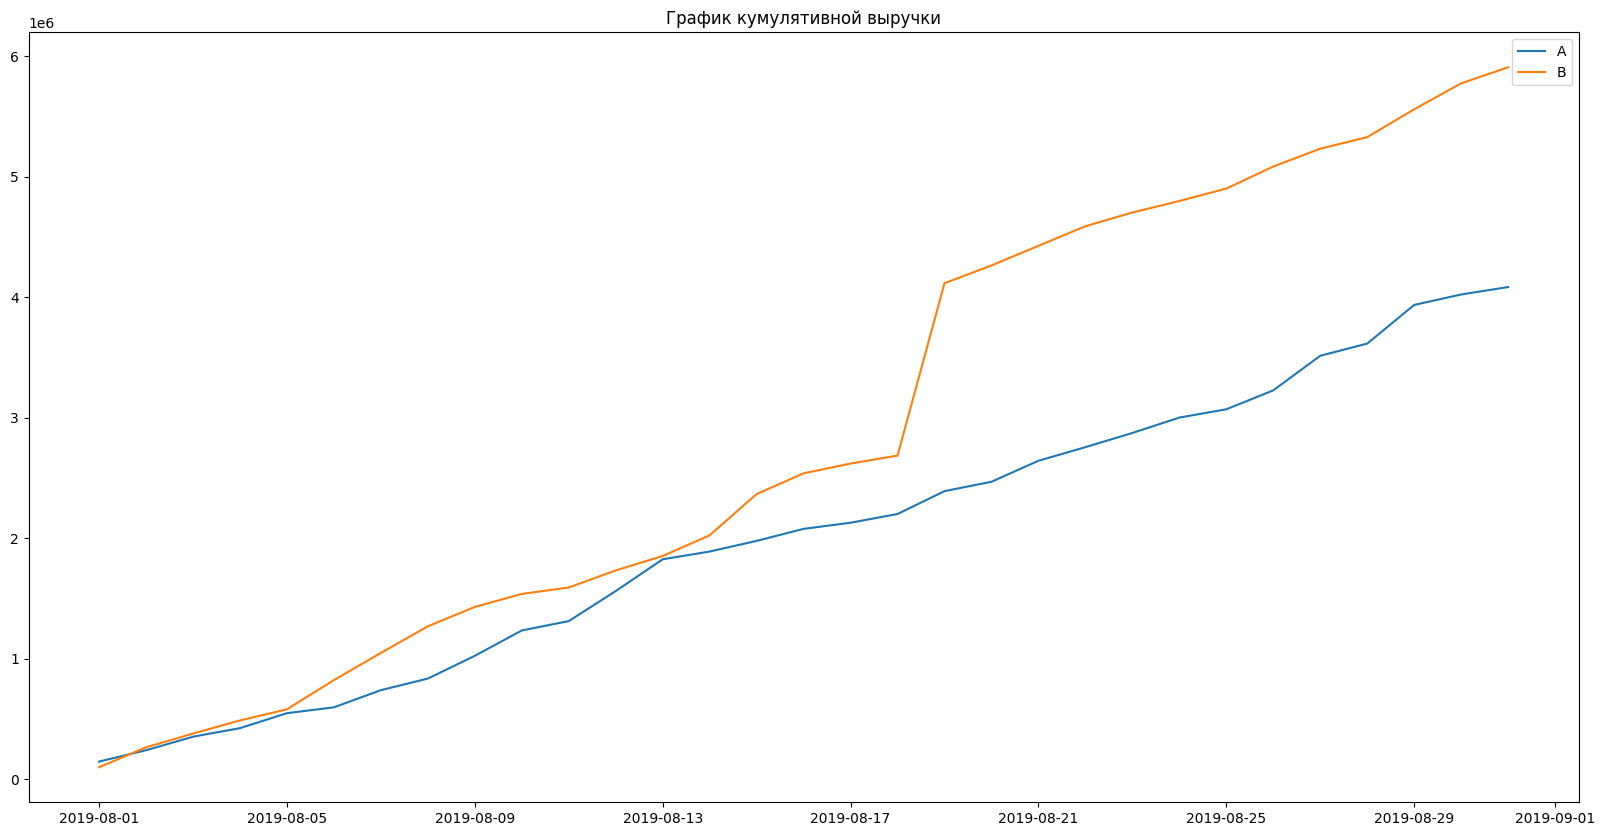

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим графики
plt.figure(figsize=(20, 10))
plt.title('График кумулятивной выручки')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.show()

Судя по графику накопленной выручки у группы В дела идут лучше и финансово группа В более перспективна.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

Средний чек получим разделив выручку на количество заказов

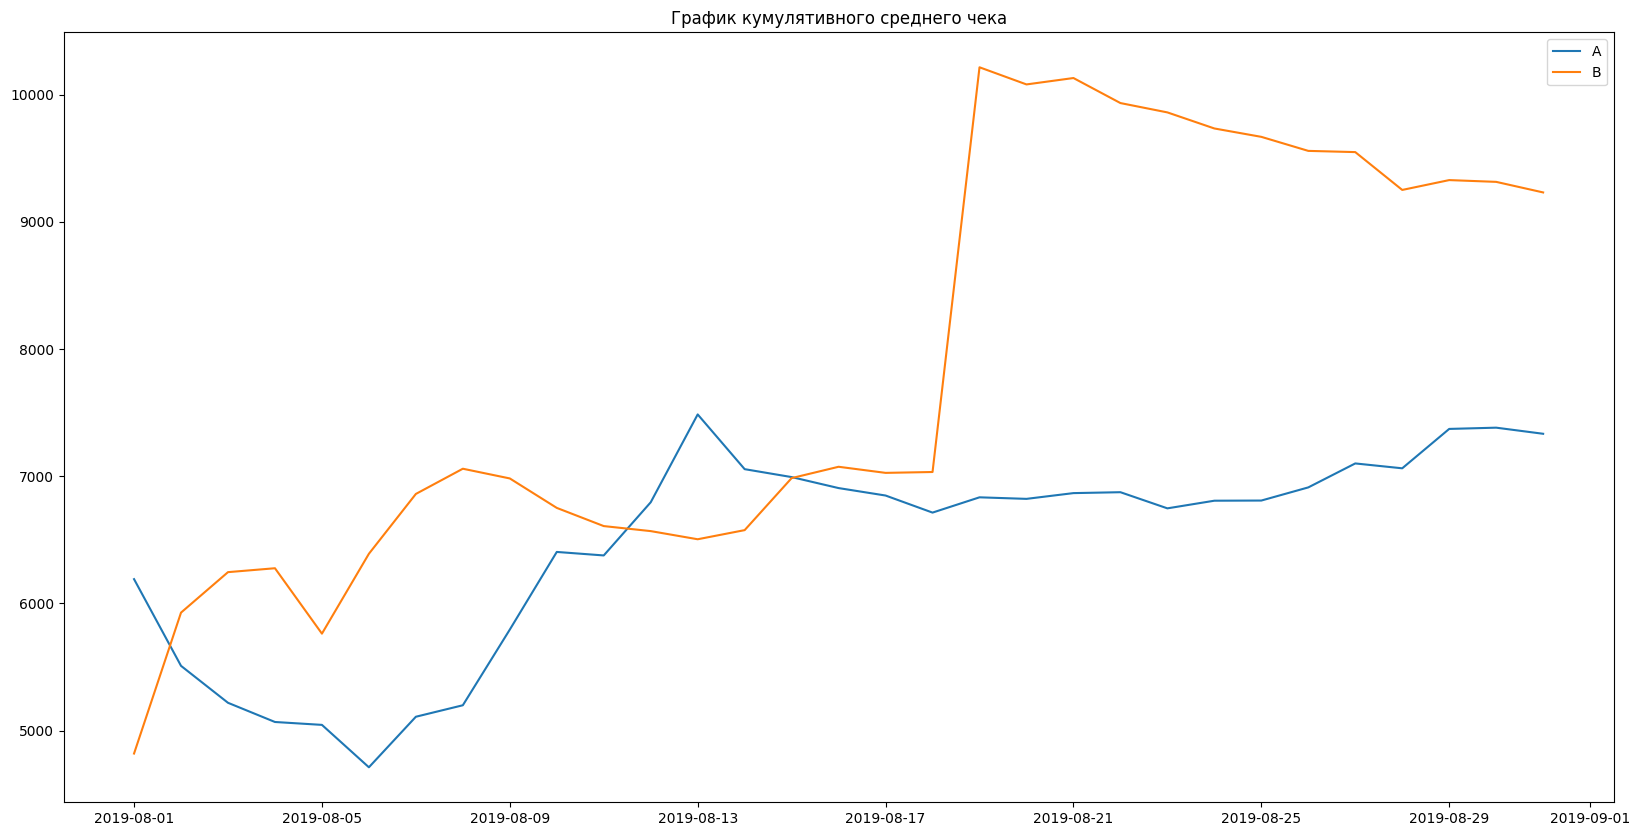

In [16]:
plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего чека')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show()

Средний чек у группы в основном выше. Резкий рост был после 18.08.19. В этот же период резко выросла средняя кумулятивная выручка. Возможно в этот период была совершена очень крупная покупка, потому что потом тренд группы В идет примерно на одном уровне. ТАкой крупный выброс искажает данные.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

Соберем кумулятивные данные в один датафрейм.

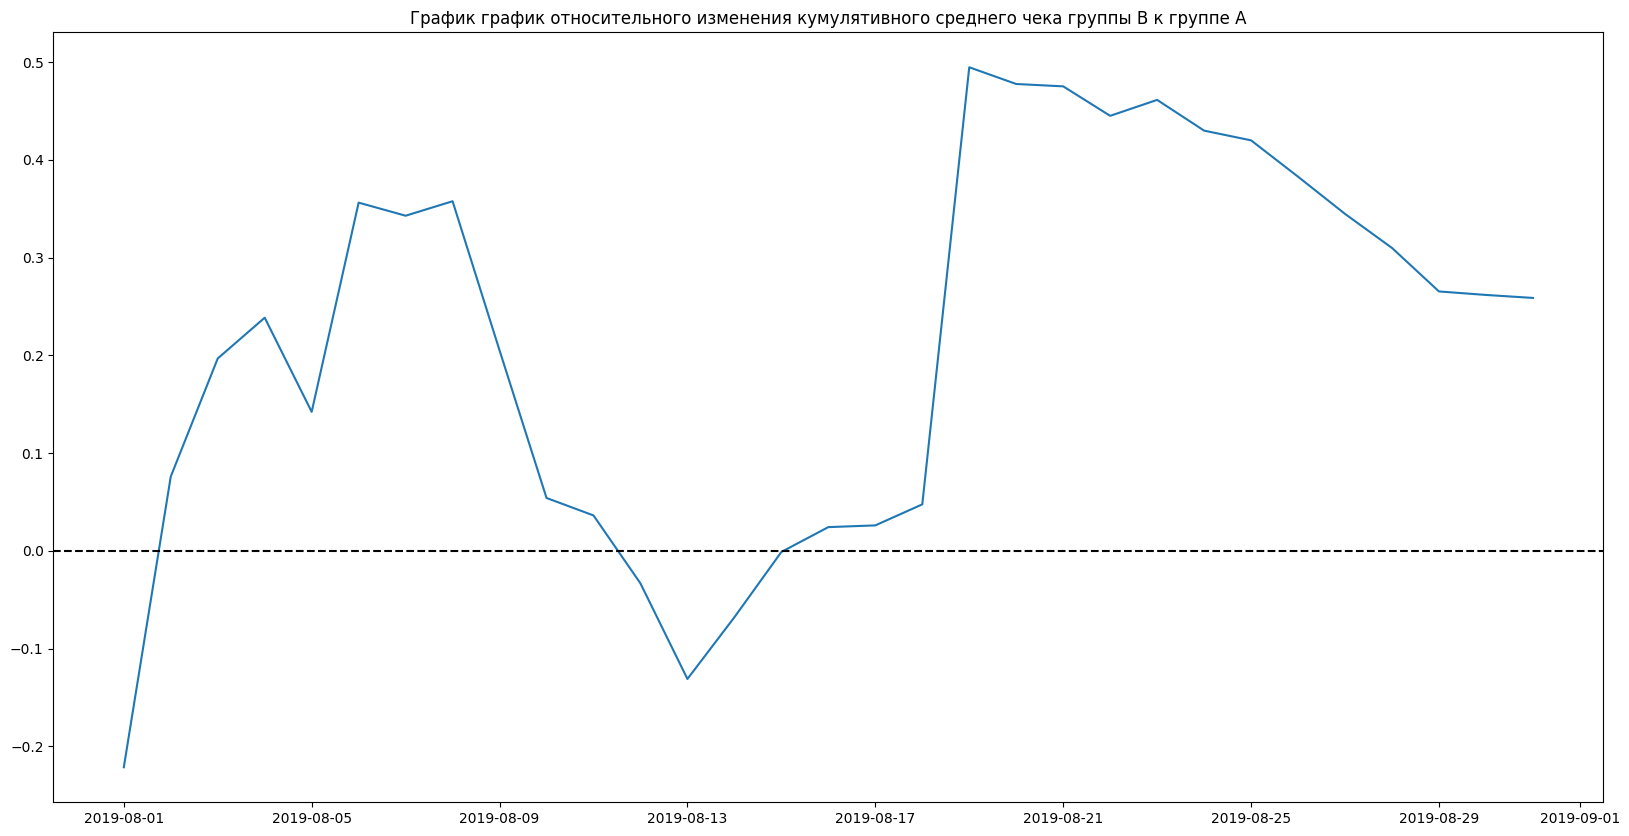

In [17]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
                                                )
plt.figure(figsize=(20, 10))
plt.title('График график относительного изменения кумулятивного среднего чека группы B к группе A')
plt.plot(mergedCumulativeRevenue['date'], \
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Из графика видим, что в целом группа B быстро опередила по среднему чеку группу А, проваал случился только 13.08.19(вероятно связано с оченькрупным выбросом в группе А). 18.08.19 очень резкий положительный скачок, что опять же предположительно связано с ркупным заказом. После этого тренд постепенно немного спадает.

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

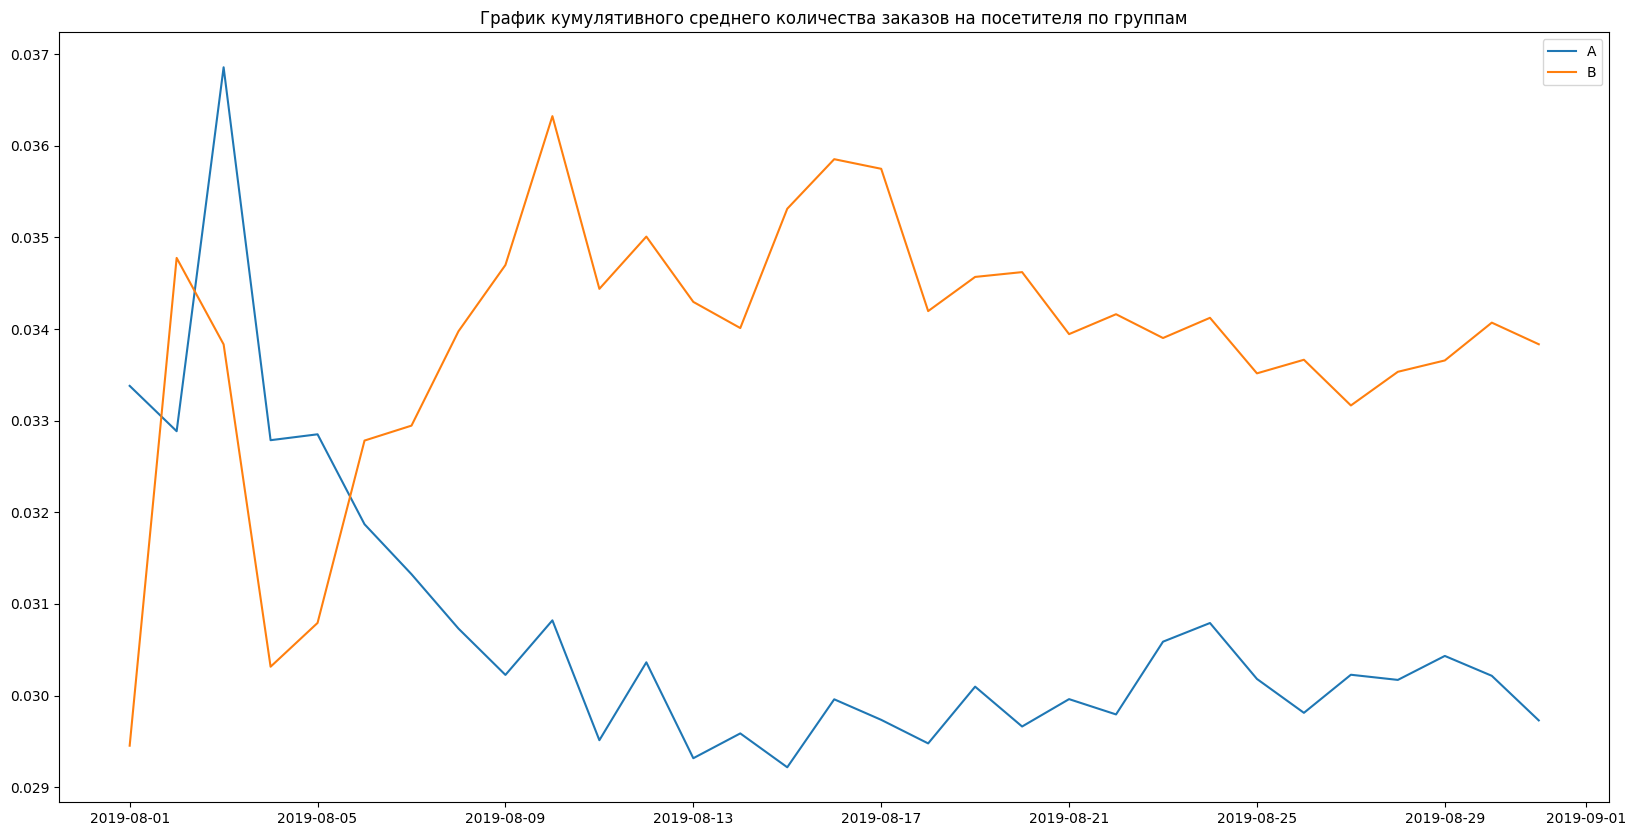

In [18]:
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date','visitors', 'orders']]
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date','visitors', 'orders']]

plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['orders']/cumulativeOrdersA['visitors'], label='A')
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['orders']/cumulativeOrdersB['visitors'], label='B')
plt.legend()
plt.show()
#cumulativeOrdersA

Сначала теста были колебания, но потом тренды нормализовались и пошли равномерно. Среднее количество заказов на 1 посетителя в группе В стабильно больше. Таким образом конверсия в группе В - выше.

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

Задачу сделаем аналогично пункту 3.3

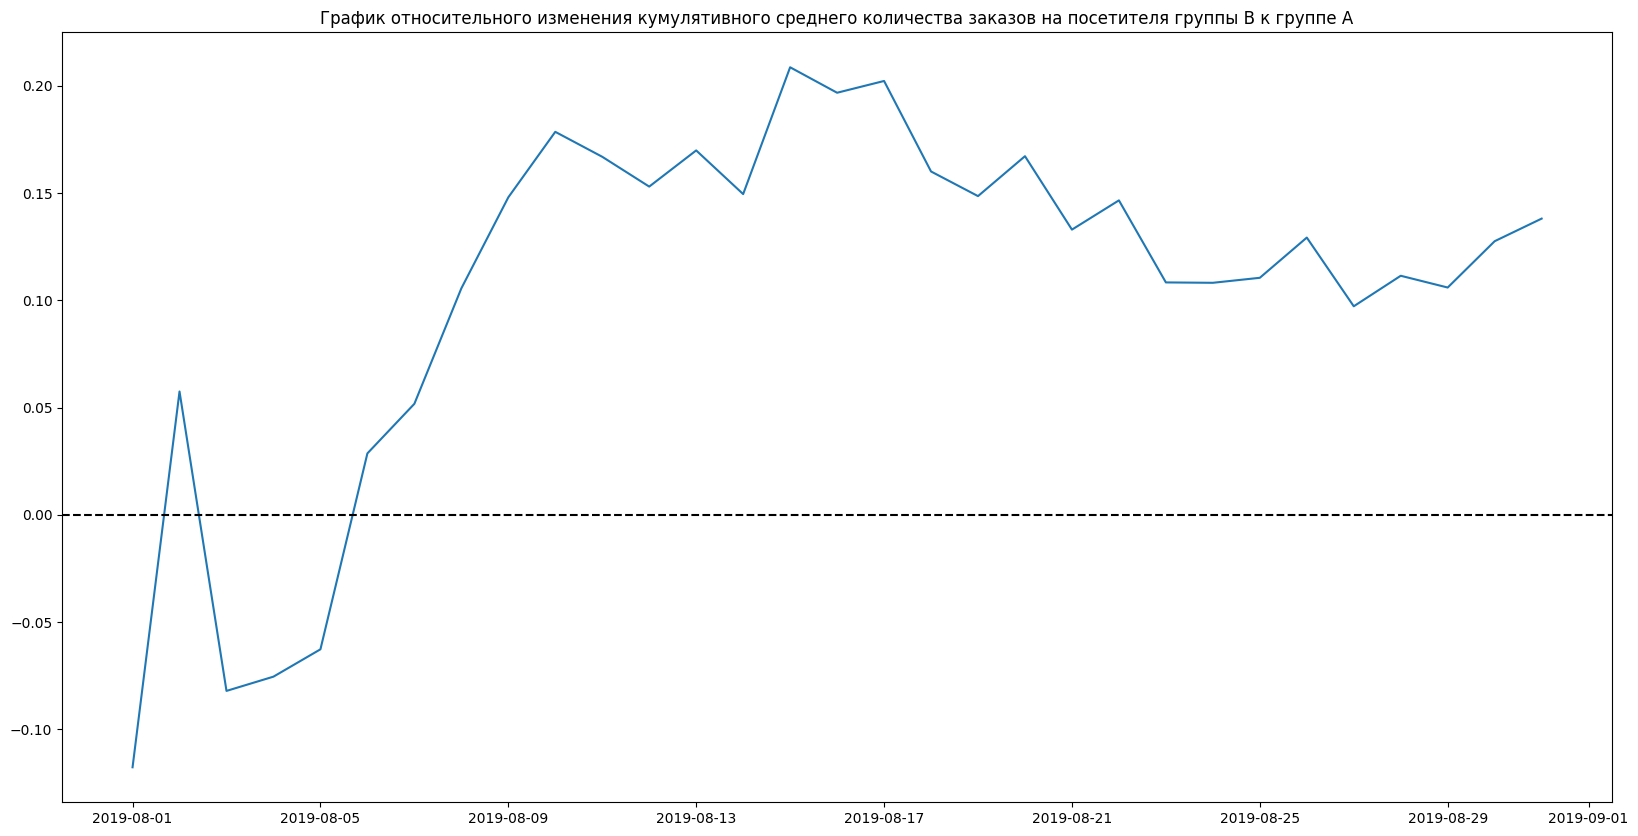

In [19]:
mergedCumulativeOrders = cumulativeOrdersA.merge(
    cumulativeOrdersB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
                                                )
plt.figure(figsize=(20, 10))
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.plot(mergedCumulativeOrders['date'], \
    (mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['visitorsB'])\
    /(mergedCumulativeOrders['ordersA']/mergedCumulativeOrders['visitorsA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Все соотносится с предыдущим пунктом. Конверсия в группе В стабильно выше, чем в группе А.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

Для построения графика создадим датафрейм с указанием id покупателя и количества заказов

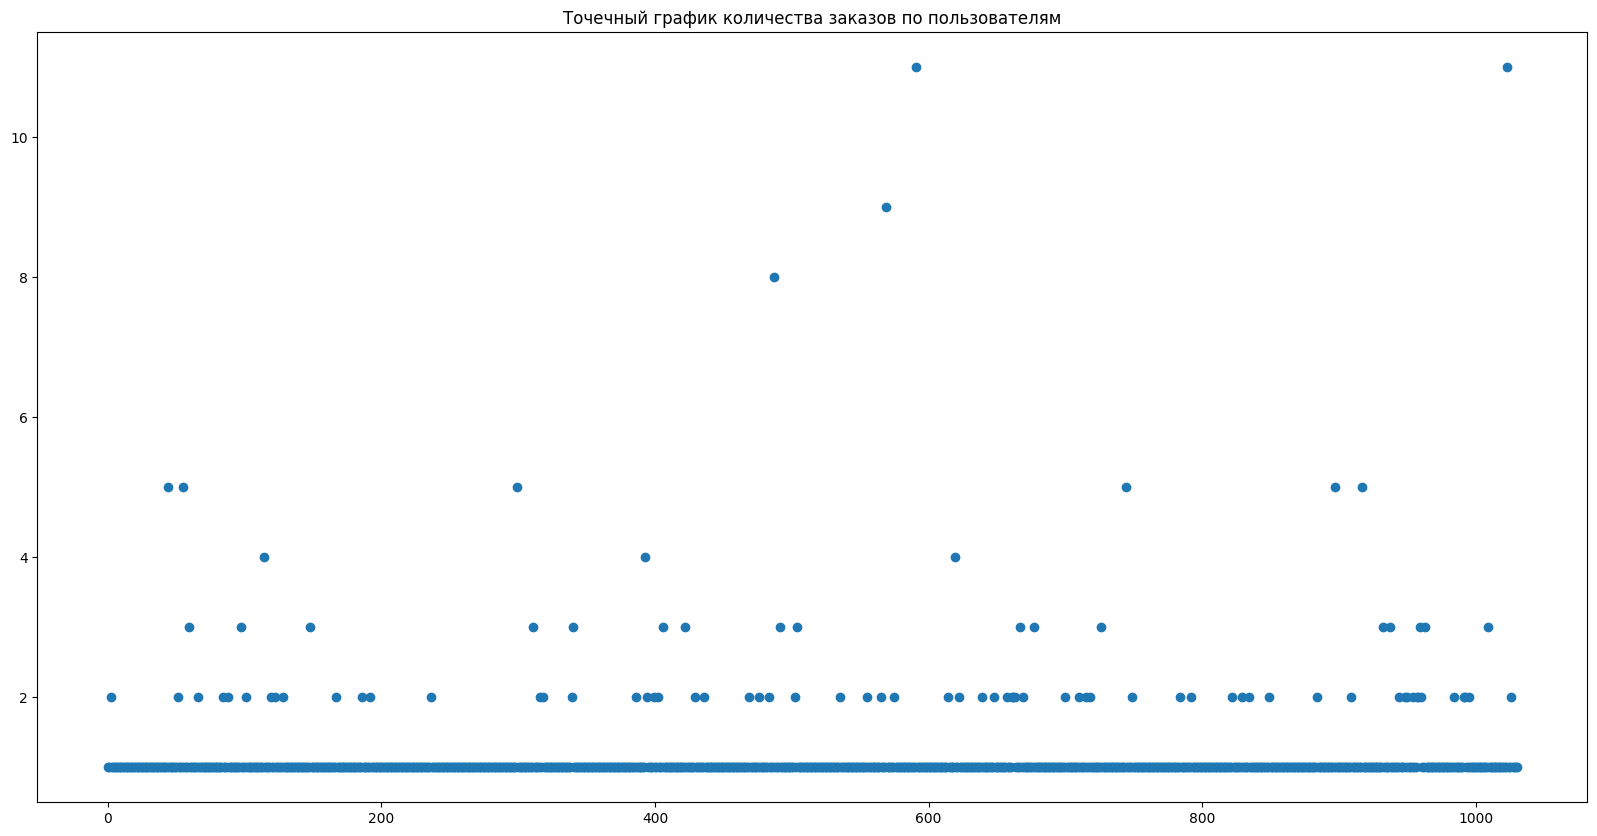

In [20]:
ordersByUsers = (orders.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))
ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(20, 10))
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Как видно из графика - основная масса посетителей совершает по одному заказу, в более редких случаях - по два-три заказа. Лишь пять человек осуществили более 5 заказов.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [21]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 1% пользователей совершает более 4 заказов. Не более 5% совершает более 2 заказов.
Ориентируясь по графику можно сказать, что аномальными пользователями являются пользователи  с числом заказов более 5.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

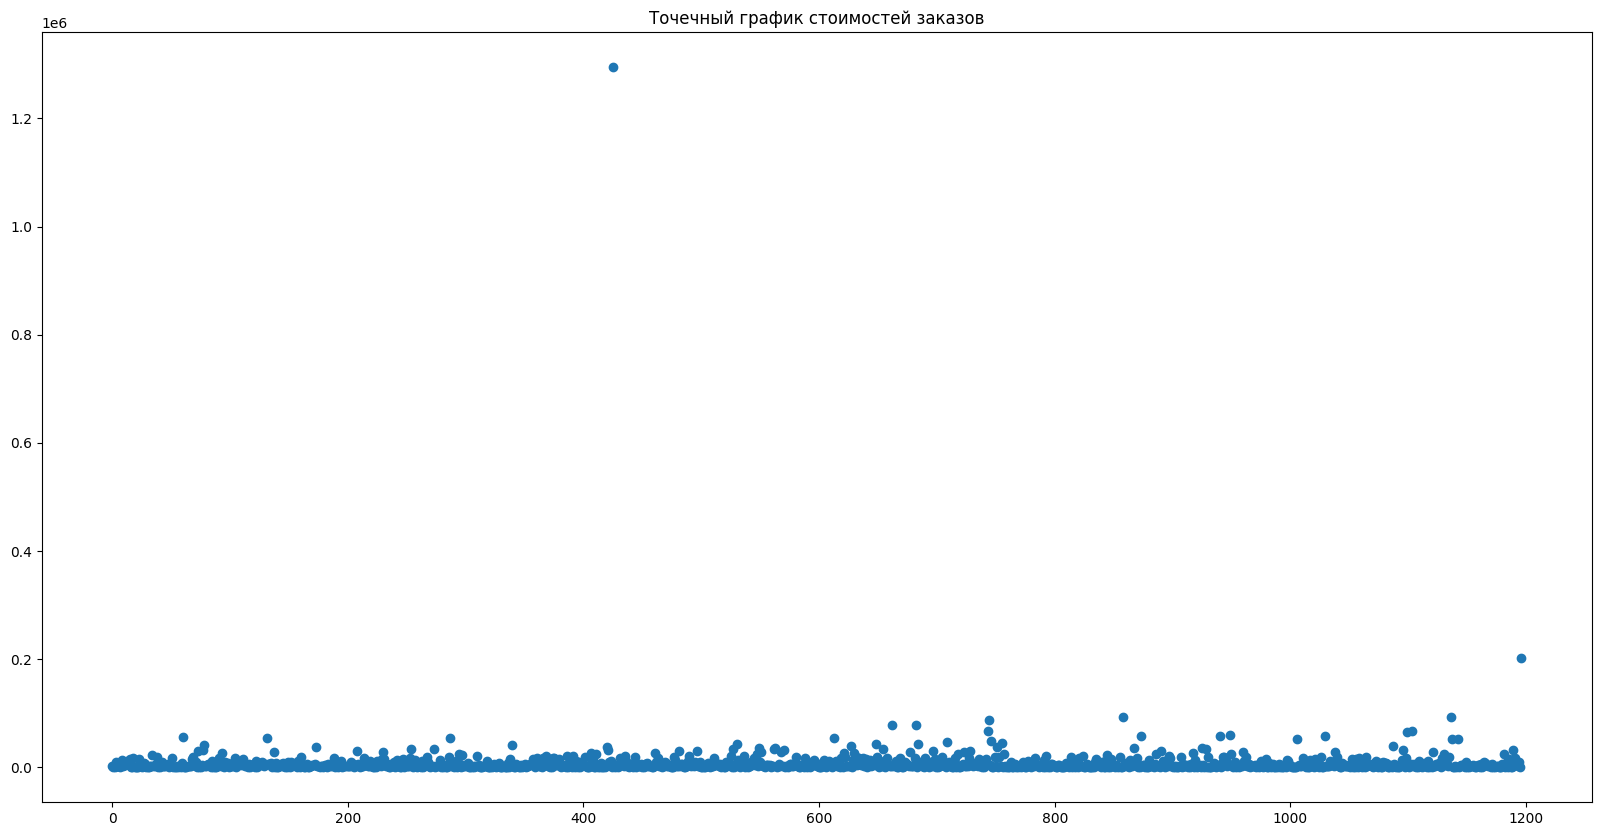

In [22]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(20, 10))
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, orders['revenue'])
plt.show()

Вот и выявлен нарушитель спокойствия. Основная масса заказов обладает стоимостью до 100к. Один же заказ был сдеан почти на 1,3кк, что как раз приводит к сильным скачкам на графиках кумулятивного среднего чека и выручки.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [23]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 1% заказов стоят более 58233,2. Не более 5% заказов стоят более  28000.

Учитывая, насколько редки аномалии на точечном графике стоимости заявок - выберем границу дл яопределения аномальных заказов в 60000. Выше такой стоимости обладают менее 1% заказов.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.


In [24]:
#Соберем сырые данные в один датафрейм initial_data
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']] \
                        .agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']] \
                        .agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#нам в дальнейшем задании надо будет посчитать средние чеки, поэтому добавим сразу сведения о выручке
ordersADaily = (orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']] \
    .groupby('date', as_index=False) \
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']] \
                    .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1,) \
                    .sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']] \
    .groupby('date', as_index=False) \
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']] \
                    .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1) \
                    .sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

initial_data = (ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
                )

#Создадим переменные для каждой группы с указанием кол-ва заказов для пользователей, у которых есть хотя бы один заказ
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('visitorid', as_index=False) \
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersB = (orders[orders['group'] == 'B'].groupby('visitorid', as_index=False) \
                  .agg({'transactionid': pd.Series.nunique}))
ordersByUsersB.columns = ['userId', 'orders']


#В следующих переменных будут пользователи из разных групп которым будет соответствовать количество заказов
#Тем, кто ничего не заказал, будут соответствовать нули.
#Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(initial_data['visitorsPerDateA'] \
                    .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(initial_data['visitorsPerDateB'] \
                    .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


#Проверяем выборки критерием Манна-Уитни
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
относительный прирост среднего числа заказов группы B: 0.138


p-value менее 0,05. Это значит, что нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет - **отвергаем**.
Статистический прирост в среднем по числу заказов в группе В - больше на 13%.

Согласно исследованию "сырых" данных - прирост среднего числа заказов в группе В - 13,8%

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Данные мы заготовили заранее, поэтому сейчас сразу проведем вы борку критерием Манна-Уитни.

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [25]:
print('p-value', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'] \
                                          , orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека заказа группы B:', '{0:.3f}' \
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value 0.729
Относительный прирост среднего чека заказа группы B: 0.259


p-value более 0,05. Это значит, что нулевую гипотезу о том, различий в среднем чеке между группами нет - **не отвергаем**.

И вместе с тем статистический прирост среднего чека в группе В - 25,9%.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Гипотезы оставим те же.
 * Нулевая: различий в среднем количестве заказов между группами нет.
 * Альтернативная: различия в среднем между группами есть.

95-й и 99-й перцентили стоимости заказов равны 28000 и 58233.2 единицам.

А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 60 000 рублей. Так мы уберём менее 1% пользователей с наибольшим числом заказов и менее 1% пользователей с дорогими заказами.

Объединим их в таблице crazyUsers.

In [26]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 5]['userId'] \
                                 , ordersByUsersB[ordersByUsersB['orders'] > 5]['userId']], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 60000]['visitorid']

crazyUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0) \
    .drop_duplicates().sort_values())

display(crazyUsers.head(5))
print('Количество аномальных пользователей - ', crazyUsers.shape[0])

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64

Количество аномальных пользователей -  12


In [27]:
# Посмотрим, как их действия повлияли на результаты теста
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(crazyUsers))]['orders'], \
                pd.Series(0, index=np.arange(initial_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])) \
                            , name='orders')], axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(crazyUsers))]['orders'], \
                pd.Series(0, index=np.arange(initial_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])) \
                            , name='orders')], axis=0,)

print('p-value', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительный прирост среднего числа заказов группы B:', '{0:.3f}' \
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value 0.013
относительный прирост среднего числа заказов группы B: 0.151


p-value менее 0,05. Это значит, что нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет - **отвергаем**. Статистический прирост в среднем по числу заказов в группе В - больше на 15%.

Сильных изменений не заметно после отбрасывани яаномальных пользователей.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [28]:
print('p-value', '{0:.3f}'.format(
        stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid']\
        .isin(crazyUsers)))]['revenue'], orders[np.logical_and(orders['group'] == 'B', \
        np.logical_not(orders['visitorid'].isin(crazyUsers)))]['revenue'],)[1]
                                ))

print('Относительный прирост среднего чека заказа группы B:', \
      "{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B', \
        np.logical_not(orders['visitorid'].isin(crazyUsers)))]['revenue'].mean() \
        / orders[np.logical_and(orders['group'] == 'A', \
        np.logical_not(orders['visitorid'].isin(crazyUsers)))]['revenue'].mean()- 1))

p-value 0.645
Относительный прирост среднего чека заказа группы B: 0.012


p-value более 0,05. Это значит, что нулевую гипотезу о том, различий в среднем чеке между группами нет - **не отвергаем**.

И вместе с тем статистический прирост среднего чека в группе В - всего 1.2%.

p-value стал чуть меньше, но все равно остался примерно на том же уровне, что и был по "сырым" данным. А вот статиcтический прирост среднего чека по данным, "очищенным" от аномалий оказался настолько мизерным, что его можно не брать в расчет.


Для сравнения построим снова графики среднего кумулятивного количества заказов на посетителя и среднего чека по группам

In [29]:
ordersFiltered = orders[orders['revenue'] < 60000]
ordersByUsersAFiltered = ordersByUsersA[ordersByUsersA['orders'] < 5]
ordersByUsersBFiltered = ordersByUsersB[ordersByUsersB['orders'] < 5]

In [30]:
datesGroupsFiltered = ordersFiltered[['date','group']].drop_duplicates()

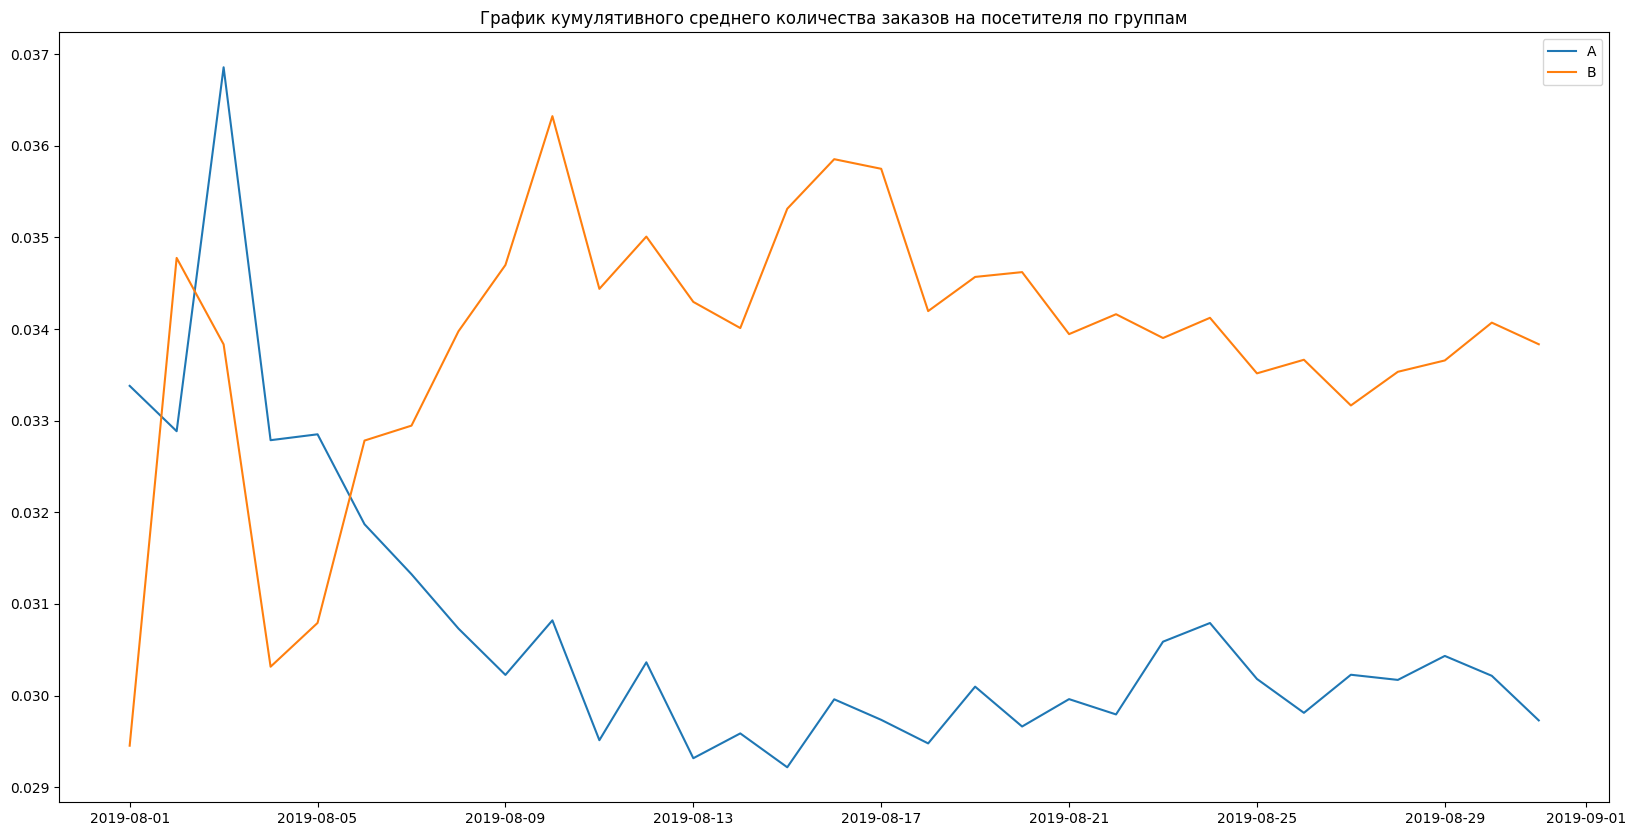

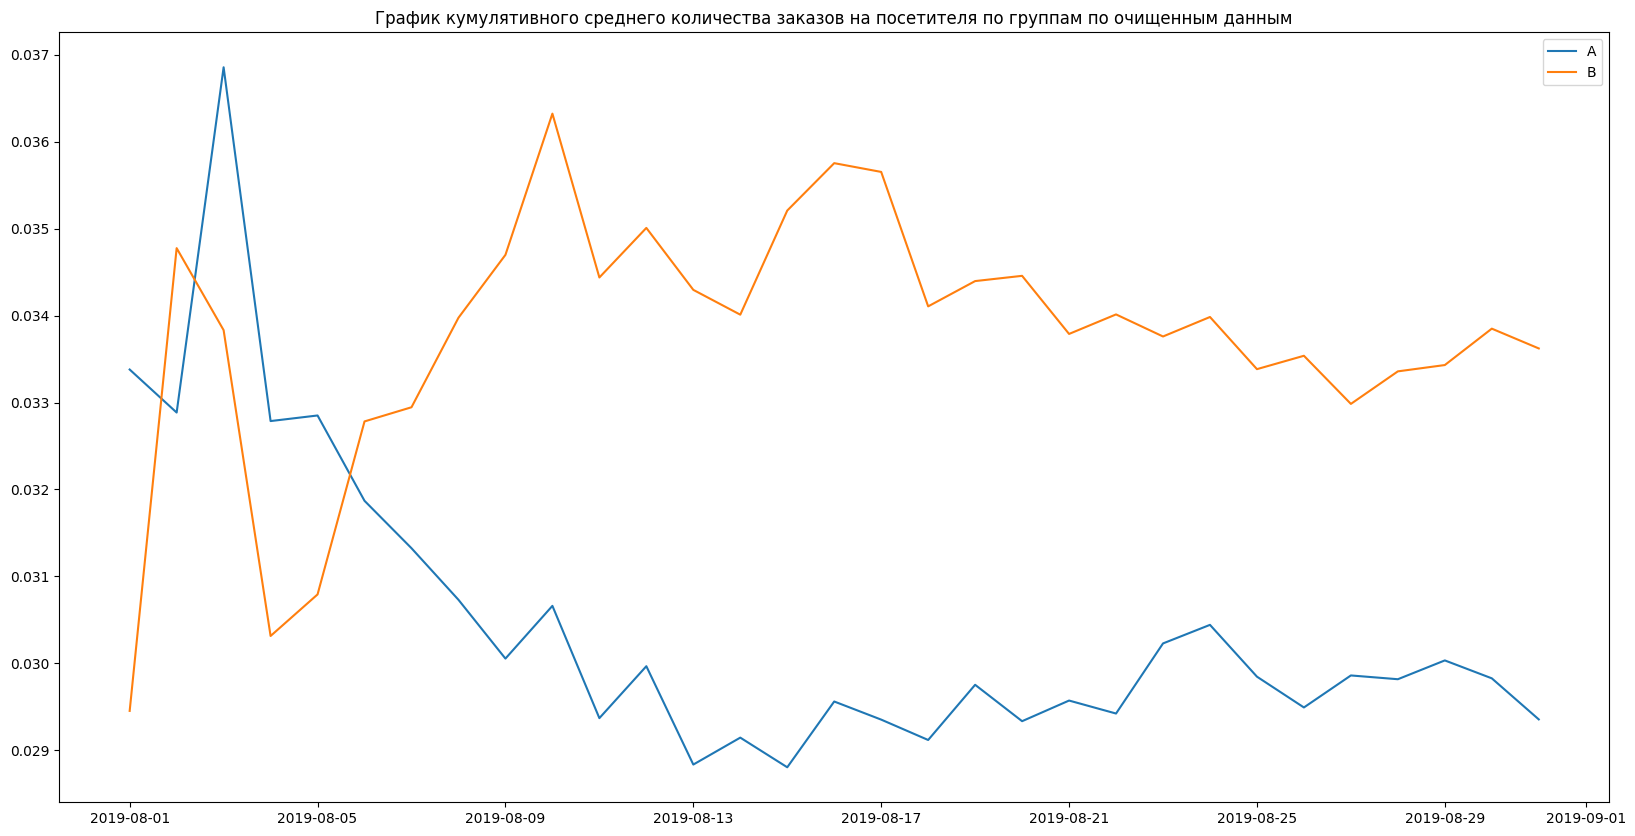

In [31]:
ordersAggregatedFiltered = datesGroupsFiltered.apply(
    lambda x: ordersFiltered[np.logical_and(ordersFiltered['date'] <= x['date'], ordersFiltered['group'] == x['group'])] \
    .agg({'date':'max', 'group':'max', 'transactionid':'nunique', 'visitorid':'nunique', 'revenue':'sum'}) \
    , axis=1
                                    ) \
    .sort_values(by=['date','group'])

cumulativeDataFiltered = ordersAggregatedFiltered.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeDataFiltered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeOrdersAFiltered = cumulativeDataFiltered[cumulativeDataFiltered['group']=='A'][['date','visitors', 'orders']]
cumulativeOrdersBFiltered = cumulativeDataFiltered[cumulativeDataFiltered['group']=='B'][['date','visitors', 'orders']]

cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date','visitors', 'orders']]
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date','visitors', 'orders']]

plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['orders']/cumulativeOrdersA['visitors'], label='A')
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['orders']/cumulativeOrdersB['visitors'], label='B')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего количества заказов на посетителя по группам по очищенным данным')
plt.plot(cumulativeOrdersAFiltered['date'], cumulativeOrdersAFiltered['orders']/cumulativeOrdersAFiltered['visitors'], label='A')
plt.plot(cumulativeOrdersBFiltered['date'], cumulativeOrdersBFiltered['orders']/cumulativeOrdersBFiltered['visitors'], label='B')
plt.legend()
plt.show()

Как видим - график среднего количества заказов на посетителя фактически идентичен.

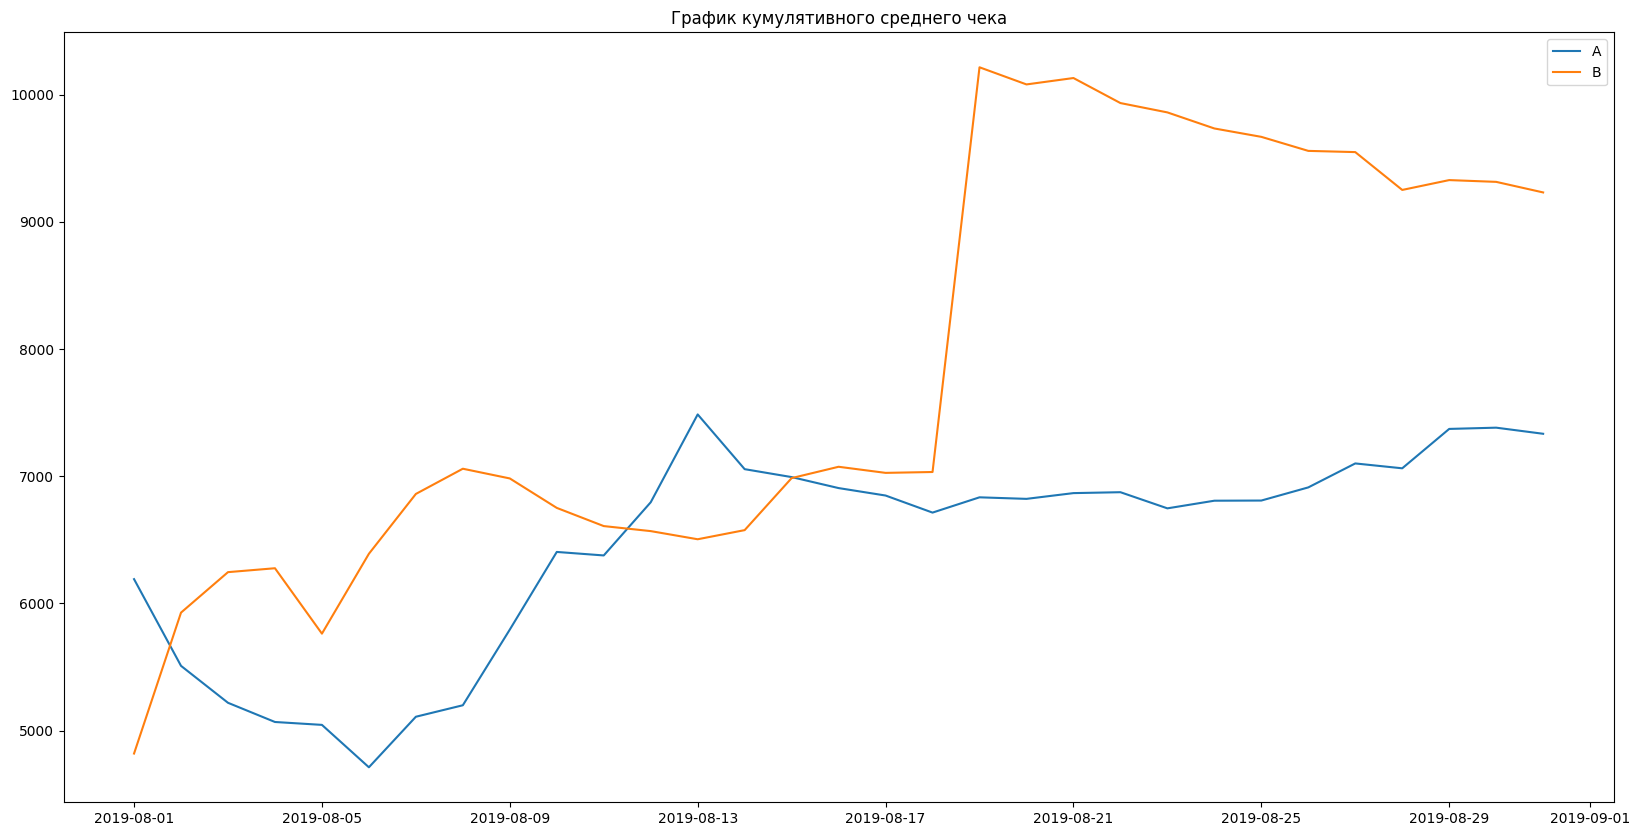

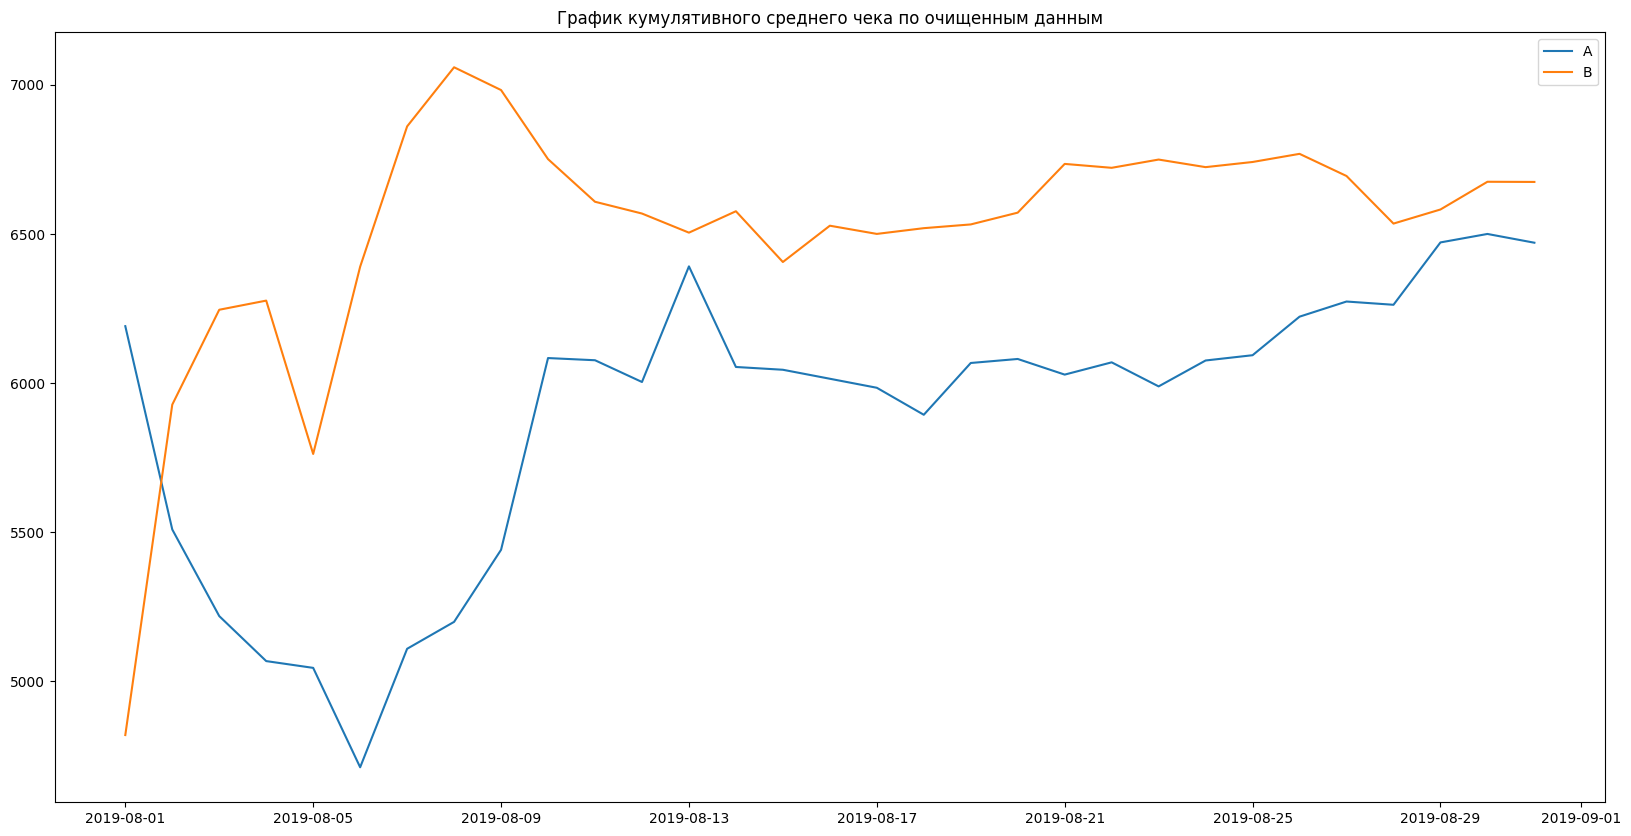

In [32]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueAFiltered = cumulativeDataFiltered[cumulativeDataFiltered['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueBFiltered = cumulativeDataFiltered[cumulativeDataFiltered['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего чека')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title('График кумулятивного среднего чека по очищенным данным')
plt.plot(cumulativeRevenueAFiltered['date'], cumulativeRevenueAFiltered['revenue'] \
         /cumulativeRevenueAFiltered['orders'], label='A')
plt.plot(cumulativeRevenueBFiltered['date'], cumulativeRevenueBFiltered['revenue'] \
         /cumulativeRevenueBFiltered['orders'], label='B')
plt.legend()
plt.show()

После удаления аномальных пользователей график стал более плавным, но значения находятся примерно на одном уровне.

### Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

Исходя из полученных данных проведенного А/В-теста можно сделать следующие выводы.
 * Существует статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий. В греппе В больше количество заказов на посетителя;
 * Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

 Исходя из приведенных данных - признаем проведенный тест успешным. Конверсия в группе В увеличивается на 15%. Дальнейшее тестирование не требуется, т.к приведет к излишним временным и материальным затратам.